# IR

## Dataset handler

In [ ]:
import pandas as pd

In [ ]:
# LINK: https://www.kaggle.com/hacker-news/hacker-news-posts
dataset = pd.read_csv('HN_posts_year_to_Sep_26_2016.csv', nrows=10000, usecols=['title'])

In [ ]:
dataset.head()

,title
0,You have two days to comment if you want stem ...
1,SQLAR the SQLite Archiver
2,What if we just printed a flatscreen televisio...
3,algorithmic music
4,How the Data Vault Enables the Next-Gen Data W...


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   10000 non-null  object
dtypes: object(1)
memory usage: 78.2+ KB


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

(array([ 656., 1335., 1946., 2168., 1830., 1259.,  559.,  193.,   48.,
           6.]),
 array([ 1. ,  3.1,  5.2,  7.3,  9.4, 11.5, 13.6, 15.7, 17.8, 19.9, 22. ]),
 <a list of 10 Patch objects>)

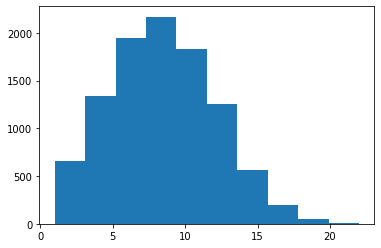

In [ ]:
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
texts = list(dataset['title'].values)
lens = list(map(lambda x: len(word_tokenize(x)), texts))
plt.hist(lens)

## Preprocessing

### Removing stopwords

In [ ]:
import json
import requests

In [ ]:
url = "https://countwordsfree.com/stopwords/english/json"
response = pd.DataFrame(data = json.loads(requests.get(url).text), columns=['words'])
SW = list(response['words'])
texts = list(map(lambda x: ' '.join([word for word in word_tokenize(x) if word not in (SW)]), texts))

### Stemming

In [ ]:
from nltk.stem.snowball import SnowballStemmer

In [ ]:
stemmer = SnowballStemmer('english')
texts = list(map(lambda x:' '.join([stemmer.stem(y) for y in word_tokenize(x)]), texts))

### Vectorize

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(texts, min_df=2, ngram_range=(1,3), max_features=20000)
tfidf.fit(texts)
vectorize_texts = tfidf.transform(texts)

In [ ]:
vectorize_texts.shape

(10000, 12855)

## Cosine similarities to find suitable news

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
articles = list(dataset['title'].values)

In [ ]:
query = 'webrtc'
query = list(map(lambda x:' '.join([stemmer.stem(y) for y in word_tokenize(x)]), [query]))
new_features = tfidf.transform(query)
cosine_similarities = linear_kernel(new_features, vectorize_texts).flatten()
related_docs_indices = cosine_similarities.argsort()[::-1]

topk = 5
print(f"Top-{topk} documents")
for i in range(topk):
  print(i + 1, articles[related_docs_indices[i]])

Top-5 documents
1 WebRTC Weekly
2 WebRTC that will help you cook better
3 Welcome Kurento WebRTC Team to Twilio
4 Wowza Media Streaming Engine Announces Support for WebRTC (Beta)
5 Ask HN: WebRTC onion routing between Facebook friend circles


# Topic modeling

## Dataset handler

In [1]:
%cd drive/MyDrive/NLP_Introduction/NLP_research/

/content/drive/MyDrive/NLP_Introduction/NLP_research


In [3]:
import pandas as pd
# LINK: https://www.kaggle.com/c/learn-ai-bbc/data
dataset = pd.read_csv('BBC News Train.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [4]:
dataset = dataset.drop('ArticleId', axis=1)
dataset

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business
...,...,...
1485,double eviction from big brother model caprice...,entertainment
1486,dj double act revamp chart show dj duo jk and ...,entertainment
1487,weak dollar hits reuters revenues at media gro...,business
1488,apple ipod family expands market apple has exp...,tech


In [5]:
corpus = dataset['Text'].values

## Preprocessing

### Tokenize

In [7]:
import nltk
import re

regex = re.compile('[^a-zA-Z]')

def tokenize(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            clean_word = regex.sub('', word)
            tokens.append(clean_word.lower())
    return tokens

### Remove stop words

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
from nltk.corpus import stopwords as sw
stopwords = sw.words('english')

### Stemming

In [10]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def stem(word):
    return stemmer.stem(word).strip()

### Vectorize

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=20000,
                                 min_df=0.05, stop_words=stopwords,
                                 use_idf=True, tokenizer=tokenize,
                                  lowercase=True, preprocessor=stem)
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

## LDA

In [21]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [22]:
for i,topic in enumerate(lda.components_):
    print(f'Topic #{i}:')
    print([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Topic #0:
['match', 'play', 'world', 'players', 'cup', 'first', 'club', 'win', 'england', 'game']


Topic #1:
['economy', 'mr', 'bank', 'growth', 'market', 'company', 'year', 'firm', 'us', 'bn']


Topic #2:
['phone', 'use', 'digital', 'new', 'technology', 'users', 'software', 'mobile', 'music', 'people']


Topic #3:
['howard', 'minister', 'would', 'government', 'brown', 'party', 'blair', 'election', 'labour', 'mr']


Topic #4:
['law', 'us', 'star', 'films', 'mr', 'award', 'awards', 'actor', 'best', 'film']




In [23]:
topic_values = lda.transform(tfidf_matrix)
doc_num, topic_num = topic_values.shape

In [24]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5)
lda.fit(tfidf_matrix)import pandas as pd
df = pd.DataFrame({'document': corpus, 'label': dataset['Category'], 'lda': topic_values.argmax(axis=1)})
df.groupby(['label', 'lda']).count()

document
label         lda          
business      0           2
              1         321
              2           9
              4           4
entertainment 0          24
              1           5
              2          59
              3           1
              4         184
politics      0           6
              1          22
              2          16
              3         193
              4          37
sport         0         335
              1           4
              4           7
tech          0           5
              1           8
              2         242
              4           6

In [26]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=2021)
lda.fit(tfidf_matrix)
for i,topic in enumerate(lda.components_):
    print(f'Topic #{i}:')
    print([tfidf_vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Topic #0:
['tv', 'films', 'music', 'star', 'actor', 'show', 'award', 'awards', 'best', 'film']


Topic #1:
['use', 'net', 'digital', 'phone', 'music', 'technology', 'users', 'software', 'mobile', 'people']


Topic #2:
['government', 'party', 'win', 'election', 'blair', 'england', 'game', 'labour', 'would', 'mr']


Topic #3:
['shares', 'economy', 'growth', 'bank', 'year', 'market', 'company', 'firm', 'us', 'bn']


Topic #4:
['december', 'problem', 'american', 'match', 'november', 'comes', 'leading', 'event', 'open', 'injury']


